In [7]:
#양방향 LSTM을 이용함.
#케라스를 이용한 태깅 작업


#양방향 LSTM
# model.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))


In [2]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력


품사 태깅이 된 문장 개수:  3914


In [3]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [4]:
sentences,pos_tags=[],[]
for tagged_sentence in tagged_sentences:#3914개 문장샘플을 1개씩 불러온다.
    sentence,tag_info=zip(*tagged_sentence) #각 샘플에서 단어들은 sentence에 품사 태깅 정보를 tag_info에 저장
    sentences.append(list(sentence))#각 샘플에서 단어정보만 저장한다.
    pos_tags.append(list(tag_info))#각 샘플에서 품사 태깅정보만 저장한다.
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


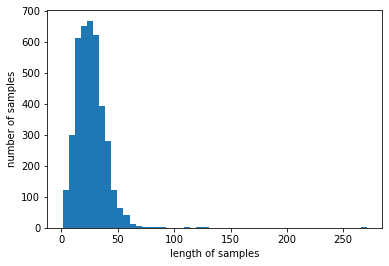

In [5]:
#그래프 그리기
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
#토큰화를 통해 정수 인코딩을 진행
def tokenize(samples):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [7]:
src_tokenizer=tokenize(sentences)
tar_tokenizer=tokenize(pos_tags)
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [8]:
#정수 인코딩 진행
X_train = src_tokenizer.texts_to_sequences(sentences) #문장 데이터에 대한 정수 인코딩
y_train = tar_tokenizer.texts_to_sequences(pos_tags) #태깅 데이터에 대해서 정수 인코딩 결과
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [9]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
#모든 샘플의 길이를 150으로

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)
#훈련데이터와 테스트 데이터를 8:2비율로 분리(과잉 적합 해소)

In [11]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
#원 핫 인코딩 : 데이터를 수많은 0과 하나의 1로 구별하는 것.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam #학습률을 담금질 하기 위한 Adam함수
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))
#epoch는 하나의 반복을 의미함.

Epoch 1/6
25/25 [==============================] - 32s 1s/step - loss: 0.5744 - accuracy: 0.1311 - val_loss: 0.5073 - val_accuracy: 0.1565
Epoch 2/6
25/25 [==============================] - 32s 1s/step - loss: 0.4918 - accuracy: 0.2180 - val_loss: 0.4614 - val_accuracy: 0.3385
Epoch 3/6
25/25 [==============================] - 34s 1s/step - loss: 0.4095 - accuracy: 0.4357 - val_loss: 0.3281 - val_accuracy: 0.5190
Epoch 4/6
25/25 [==============================] - 35s 1s/step - loss: 0.2560 - accuracy: 0.6251 - val_loss: 0.1902 - val_accuracy: 0.7236
Epoch 5/6
25/25 [==============================] - 36s 1s/step - loss: 0.1380 - accuracy: 0.8236 - val_loss: 0.1056 - val_accuracy: 0.8581
Epoch 6/6
25/25 [==============================] - 35s 1s/step - loss: 0.0716 - accuracy: 0.9108 - val_loss: 0.0679 - val_accuracy: 0.9007


In [13]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 3s 139ms/step - loss: 0.0679 - accuracy: 0.9007

 테스트 정확도: 0.9007


In [14]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


In [15]:
#NLTK를 이용한 개체명 인식 : 챗봇에서 필요로 하는 주요 전처리 작업
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence=pos_tag(word_tokenize(sentence))
print(sentence) # 토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [16]:
sentence=ne_chunk(sentence)
print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


In [17]:
sentences="이정진 교수님 짱!"
sentences=pos_tag(word_tokenize(sentences))
print(sentences)
sentences=ne_chunk(sentences)
print(sentences)

#한국어는 안되는 걸 확인. 

[('이정진', 'JJ'), ('교수님', 'NNP'), ('짱', 'NN'), ('!', '.')]
(S 이정진/JJ (ORGANIZATION 교수님/NNP) 짱/NN !/.)
